## Phylogenetic Analysis

The goal of this notebook is to perform phylogenetic inference on the samples from the boat as well as other genomes sampled from around the same time as the boat outbreak. 

**Requirements:**
Make sure you have `Biopython`, `MAFFT`, `BLAST`, and `ETE3` installed in your environment. 


In [1]:
# Change the directory if running interactivley
%cd /fh/fast/bloom_j/computational_notebooks/whannon/2020/SARS-CoV-2_bottleneck

/fh/fast/bloom_j/computational_notebooks/whannon/2020/SARS-CoV-2_bottleneck


In [2]:
import os 
import math
from io import StringIO 
from itertools import combinations, product
from collections import Counter, defaultdict
from subprocess import call 

import pandas as pd
import numpy as np
from ete3 import Tree, TreeStyle, NodeStyle, TextFace, SequenceFace, CircleFace, faces, AttrFace 
from Bio import SeqIO, AlignIO, SeqRecord, Seq 
from Bio.Align.Applications import MafftCommandline 

In [3]:
# Path to output directory
outpath = "results/phylogeny"

if not os.path.exists(outpath):
    os.mkdir(outpath)

## Functions for Phylogenetic Trees

These functions are used to make the phylogenetic trees with `MAFFT` for the alignment and `IQtree` for the phylodynamic inference. 

In [39]:
def mask_positions(record, positions = [265, 29674]):
    """
    Positions to exclude from the ends of the genome for alignments and phylogenetics. 
    
    For now, the default will be to exclude the 3' and 5' UTRs. 
    """
    
    record.seq = record.seq[positions[0]:positions[1]]
    
    return record


def make_tree(
    fastapath, outpath, prefix, referencepath = "config/index/samtools/SARS2.fa", large = True, mask = True
    ):
    """
    Function to align sequences and build a phylogenetic tree. Alignment is 
    performed using MAFFT and tree is built with IQtree. 
    """
    
    # Path for the output aligned fasta
    alignfasta = f"{outpath}/{prefix}.aligned.fa"
    
    print(f"Aligning the fasta file: {fastapath}\n")
    
    if large:
        # When there are lots of sequences, align to a reference. -- this is default behavior 
        call(f"mafft --6merpair --thread {4} --keeplength --addfragments {fastapath} {referencepath} > {alignfasta}", shell=True)
    
    else: 
        mafft_cline = MafftCommandline(input=fastapath)
        stdout, stderr = mafft_cline()
        with open(alignfasta, "w") as handle:
            handle.write(stdout)
        
    print(f"Finshed aligning file. Alignment is located at {alignfasta}\n")
    
    # Default behavior is to make the untranslated regions of SARS-CoV-2 genome
    if mask:
        SeqIO.write([mask_positions(record) for record in SeqIO.parse(alignfasta, "fasta")], alignfasta, "fasta")
    
    print(f"Building treefile: {alignfasta}.treefile\n")
    
    # Building the phylogeny with IQtree with 1000 bootstrap iterations with GTR+I+G (Invariable site plus discrete Gamma model) with asr
    call(f"iqtree -s {alignfasta} -m GTR+I+G -bb 1000 -asr -st DNA -redo", shell=True)
    
    print(f"Finished building treefile.\n")

    
def ancestral_snps(tree, states, nodes, reference_list, offset = 265):
    """
    Function to get the SNPs (differences from a reference) for the common ancestor of a given list of nodes.
    
    Params
    ------
    tree: TreeNode
        A tree from IQtree with -asr flag.
    states: str
        A path to the the *.states file of IQtree -asr
    nodes: list
        A list of nodes to find the common ancestor of
    reference: list
        A list of the reference bases to call SNPs to
    offset: int
        The offset of the state relative to reference from sequence masking
        
    Return
    ------
    pd.DataFrame
        A table of the SNPs relative to the reference provided for an inferred ancestral state 
    """
    
    # Import the internal states from IQtree `-asr` .state file
    states_df = (
        pd.read_csv(states,
                    sep='\t',
                    comment='#',
                    usecols=['Node', 'Site', 'State'])
        .assign(Site = lambda x: x['Site'] + offset)
        )
    
    
    # Get the common ancestor to the nodes provided 
    mrca = tree.get_common_ancestor(nodes).name.split("/")[0]
    
    
    # Get the ancestral state of the MRCA 
    ancestral_state = states_df[states_df.Node == mrca]
    
    # Fill the missing sequence with the reference
    ancestral_state_dict = defaultdict(int, zip(ancestral_state.Site, ancestral_state.State))
    for position, base in list(enumerate(reference_list)):
        if position+1 not in ancestral_state_dict.keys():
            ancestral_state_dict[position+1] = base
    ancestral_state_list = sorted((position, base) for position, base in ancestral_state_dict.items())
    ancestral_state_list_with_ref = [[tup[0], reference_list[i], tup[1]] for i, tup in enumerate(ancestral_state_list)]

    # Get just the differences from the reference as a dataframe 
    consensus_snps_df = pd.DataFrame(ancestral_state_list_with_ref, columns = ["POS", "REF", "ALT"])
    consensus_snps_df['SNP'] = np.where(consensus_snps_df['REF'] == consensus_snps_df['ALT'], False, True)
    return consensus_snps_df[consensus_snps_df.SNP]
    


## Boat Genome Phylodynamics

This first part of the notebook contains an analysis of the genomes collected from the boat and **re-sequenced** from two different reverse transcription experiments. 

I made the consensus sequences with `workflow/scripts/make-consensus-sequence.py`. To do this, I took an aligned `BAM` file and counted the occurences of each nucleotide at every position. If there were less than 100 reads that covered a given site (with `BQ > 25`) then I coded this site as an `N`. Then, using both replicates, I filled in missing (`N`) nucleotides with the more highly covered positions. 

**This method doesn't take into account insertions and deletions**. Since the analysis is mostly focused on SNPs in the intrahost population, I thoguht this was reasonable.

In [5]:
# Path to the aligned sequences - aligned in the snakemake pipeline
boat_genomes_path = "results/consensus/aligned_consensus.fa"

boat_genomes = {record.id : record.seq for record in SeqIO.parse(boat_genomes_path, "fasta")}


#### Edit Distance

Here is the edit distance (hamming distance) between each of the genomes. The most divergent sample is `10136`. We know that this sample probably wasn't infected by the same virus that spread on the boat. It also doesn't seem like any of the cases on the boat came from this person. On average, there are about 2 nucleotide differences between all samples, expect for `10136` which averages ~9 differences per sample. 

In [6]:
distance = lambda x,y : sum(c1 != c2 for c1, c2 in zip(x, y))

edit_distance = {f"{g1}-{g2}": distance(boat_genomes[g1], boat_genomes[g2]) for g1, g2 in combinations(boat_genomes.keys(), 2)}
outlier_distance = {f"{g1}-{g2}": distance(boat_genomes[g1], boat_genomes[g2]) for g1, g2 in combinations(boat_genomes.keys(), 2) if g1 == '10136' or g2 == '10136'}
wout_outlier_distance = {f"{g1}-{g2}": distance(boat_genomes[g1], boat_genomes[g2]) for g1, g2 in combinations(boat_genomes.keys(), 2) if g1 != '10136' and g2 != '10136'}


print(f"The mean pairwise distance between samples is {sum(v for v in edit_distance.values()) / len(edit_distance):.2f}.\n")
print(f"However, this includes a sample (10136) that is highly diverged from the rest with a mean edit distance of {sum(v for v in outlier_distance.values()) / len(outlier_distance):.2f} from any other sample.\n")
print(f"The mean pairwise distance between samples excluding 10136 is {sum(v for v in wout_outlier_distance.values()) / len(wout_outlier_distance):.2f} from any other sample.")


The mean pairwise distance between samples is 2.13.

However, this includes a sample (10136) that is highly diverged from the rest with a mean edit distance of 8.83 from any other sample.

The mean pairwise distance between samples excluding 10136 is 1.53 from any other sample.


#### Consensus Differences 

Here are all the differences between the 24 patients and the reference (Wuhan-1). I collapsed patients with the same consensus sequecnes into a single row.

Of the 24 samples, there are two clusters of identical genomes that make up roughly half of all the resequenced samples.

In [7]:
reference = [base for record in SeqIO.parse("config/ref/SARS2.fa", "fasta") for base in record.seq]

# Get a list of differences from the reference for each boat genome. 
consesus = {}
for patient, genome in boat_genomes.items():
    differences = []
    for i, bases in enumerate(zip(reference, genome.upper())):
        if len(set(bases)) > 1: 
            differences.append((i, bases))
    consesus[patient] = differences

# Get only the unique differences
consensus_differences = set(snp for snp_list in consesus.values() for snp in snp_list)

# Fill in the missing SNPs in the dict
for patient, snps in consesus.items(): 
    for snp in consensus_differences: 
        if snp not in snps:
            consesus[patient].append((snp[0], (snp[1][0], snp[1][0])))

# Condense the identical sequences
unique_consensus = {}
for patient, snps in consesus.items(): 
    con = ' '.join([snp[1][1] for snp in sorted(snps, key = (lambda s: s[0]))])
    if con in unique_consensus.keys():
        unique_consensus[con].append(patient)
    else: 
        unique_consensus[con] = [patient]


print(f"Position: {' '.join([str(snp[0] + 1) for snp in sorted(consensus_differences, key = (lambda s: s[0]))])}")
print(f"\nReference: \t\t\t\t{' '.join([snp[1][0] for snp in sorted(consensus_differences, key = (lambda s: s[0]))])}")
for snps, patients in unique_consensus.items(): 
    print(f"\n{'/'.join(patients)}: \n\t\t\t\t\t{snps}")


Position: 241 539 1059 1255 3037 6046 7564 8290 11083 13252 13423 14408 16912 17125 17156 17352 19524 23403 25563 27311 28376 29167 29299 29553 29868 29870

Reference: 				C C C A C T C C G C C C G C C C C A G T G C A G G C

10114: 
					T C T A T T T C T C C T G C C C T G T T T C A G G A

10117/10118/10127/10130/10027/10040/10089/10091/10102/10110: 
					T C T A T T T C T C C T G C C C C G T T T C A G G A

10128: 
					T C T A T T T T T C C T G T C C C G T T T C A G G A

10129: 
					T C T A T T T T T C C T G C C C C G T T T C A G G C

10131: 
					T T T A T T T C T C C T G C C C C G T C T C A G G A

10136: 
					T C T G T C C C G C C T T C T C C G T T G C A A G A

10138: 
					T C T A T T T C T C C T G C C C C G T T T C T G G A

10028: 
					T C T A T T T T T C C T G C C C C G T T T C A G A A

10029/10094/10106: 
					T C T A T T T C T C C T G C C C C G T T T C A G A A

10039: 
					T C T A T T T C T C C T G C C C C G T T T T A G A A

10042: 
					T C T A T T T C T C T T G C C T C G 

#### Boat 'Consensus' 

These are the mutations that are different from the reference, but shared between all 24 people we've **re-sequenced** on the boat. 

In [8]:
# Save a list of the mutations shared in all 24 genomes 
all_shared_variants = []
for k,v in Counter(snp for snps in consesus.values() for snp in snps).items():
    if v == 24:
        all_shared_variants.append(k)
    
# Save a list of the mutations shared in all 24 genomes -- *EXCLUDING 10136 
shared_variants_without_10136 = []
for k,v in Counter(snp for patient, snps in consesus.items() if patient != "10136" for snp in snps).items():
    if v == 23:
        shared_variants_without_10136.append(k)

print(f"Mutations found in every patient including 10136:\n\t{[''.join([alleles[0], str(pos+1), alleles[1]]) for pos, alleles in all_shared_variants]}\n")
print(f"Mutations found in every patient EXCLUDING 10136:\n\t{[''.join([alleles[0], str(pos+1), alleles[1]]) for pos, alleles in shared_variants_without_10136]}\n")


Mutations found in every patient including 10136:
	['C241T', 'C1059T', 'C3037T', 'C14408T', 'A23403G', 'G25563T']

Mutations found in every patient EXCLUDING 10136:
	['C241T', 'C1059T', 'C3037T', 'C7564T', 'G11083T', 'C14408T', 'A23403G', 'G25563T', 'G28376T', 'G16912G', 'G29553G', 'T6046T', 'A1255A', 'C17156C']



In [9]:
variable_sites = []
for k,v in Counter(snp for snps in consesus.values() for snp in snps).items():
    if k[1][0] != k[1][1]:
        if v < 24:
            variable_sites.append(k[0])
        
print("Consensus mutations that are not shared among all re-sequenced samples:", (*sorted(variable_sites)))   

Consensus mutations that are not shared among all re-sequenced samples: 538 1254 6045 7563 8289 11082 13251 13422 16911 17124 17155 17351 19523 27310 28375 29166 29298 29552 29867 29869


#### Boat Phylogenetic Tree

Here I make a tree from the consensus samples deep-sequenced from the boat. I annotated the tree with the differences from the reference. I rooted the tree using the midpoint. You can see that `10136` is the outgroup as expected. This figure shows the phylogenetic relationship between the samples on the boat along with the nucleotide differences from the reference. 

**With all genomes:** This even includes the genomes that are identical to one another.

Aligning the fasta file: results/consensus/merged.consenus.fa

Finshed aligning file. Alignment is located at results/phylogeny/merged.consenus.aligned.fa

Building treefile: results/phylogeny/merged.consenus.aligned.fa.treefile

Finished building treefile.

Positions of differences in order: 539 1255 6046 7564 8290 11083 13252 13423 16912 17125 17156 17352 19524 27311 28376 29167 29299 29553 29868 29870


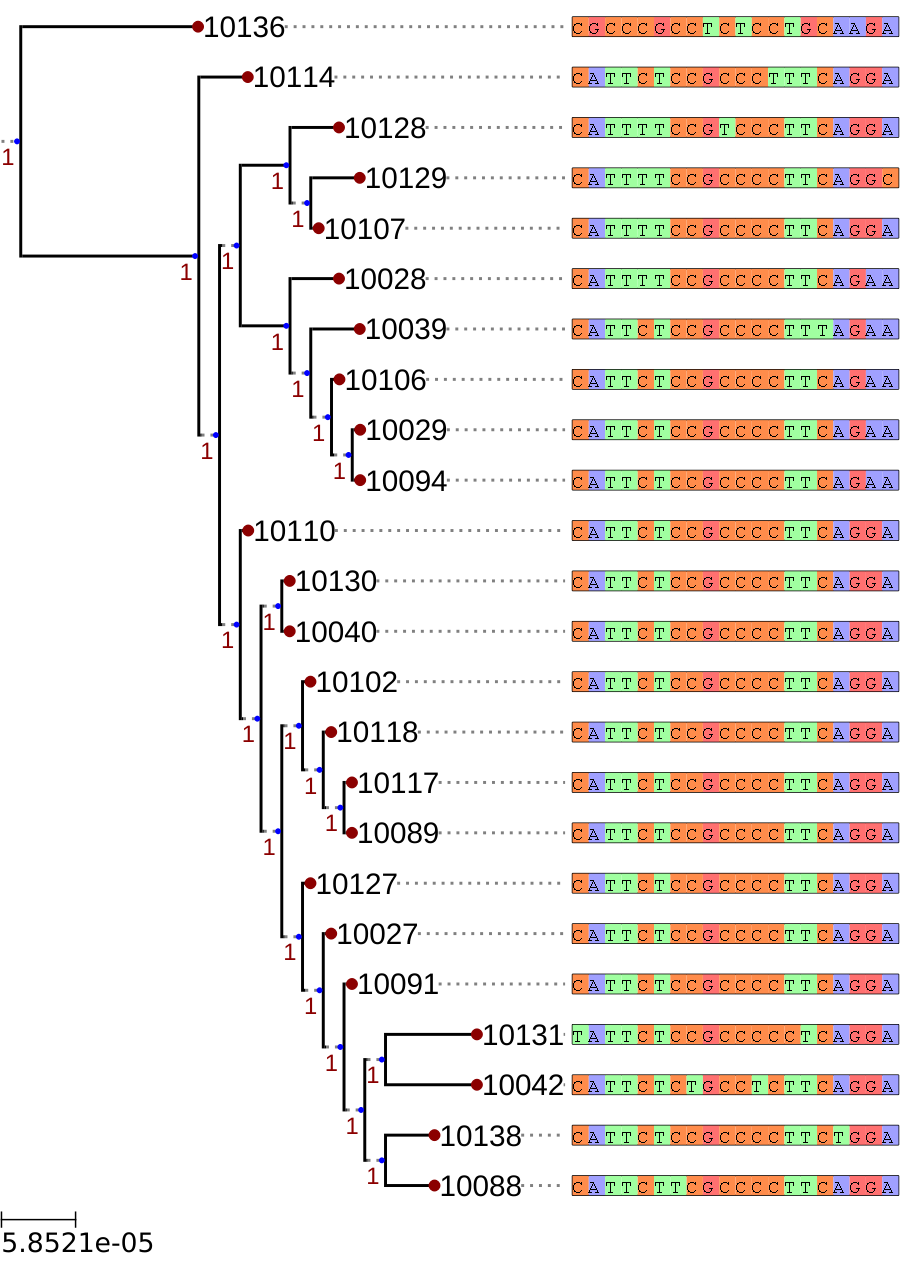

In [10]:

# Only make the tree if it hasn't already been made - otherwise this notebook takes quite a while to run. 
if not os.path.exists("results/phylogeny/merged.consenus.aligned.fa.treefile"):
    make_tree(fastapath = "results/consensus/merged.consenus.fa", outpath = outpath, prefix = "merged.consenus", large = False, mask = False)

## == Make the figure == ##
t = Tree("results/phylogeny/merged.consenus.aligned.fa.treefile", format = 1)   

# Simple midpoint rooting is sufficent
root_point = t.get_midpoint_outgroup()
t.set_outgroup(root_point)

seq_annotation = {}
for patient, snps in consesus.items(): 
    con = ''.join([snp[1][1] for snp in sorted(snps, key = (lambda s: s[0])) if snp not in all_shared_variants]) 
    seq_annotation[patient] = con
    
# Tree style - applies to the entire tree
ts = TreeStyle()
ts.show_branch_support = True
ts.branch_vertical_margin = 10 
ts.draw_guiding_lines = True

# Node styles - only applies to select nodes
leafstyle = NodeStyle()
leafstyle["shape"] = "circle"
leafstyle["size"] = 7
leafstyle["fgcolor"] = "darkred"

leafstyle["hz_line_width"] = 2
leafstyle["vt_line_width"] = 2

internalstyle = NodeStyle()
internalstyle["shape"] = "circle"
internalstyle["size"] = 3
internalstyle["fgcolor"] = "blue"
internalstyle["hz_line_width"] = 2
internalstyle["vt_line_width"] = 2

# Apply the node styles
for n in t.traverse():
    if n.is_leaf(): 
        n.set_style(leafstyle)
    else: 
        n.set_style(internalstyle)

# Apply faces to the leaves to demonstrate differences from consensus sequence 
for leaf in t.iter_leaves():
    
    if leaf.name == "10136":
        seqface = SequenceFace(seq_annotation[leaf.name], seqtype= "nt")
        seqface.margin_left = 5
        #refface = SequenceFace(''.join([snp[1][1] for snp in sorted(consensus_differences, key = (lambda s: s[0]))]), seqtype= "nt")
        #refface.margin_left = 5
        #refface.margin_bottom = 5
        #leaf.add_face(refface, 1, "aligned")
        leaf.add_face(seqface, 1, "aligned")
        #leaf.add_face(TextFace("Reference"), 0, "aligned")


    else:   
        seqface = SequenceFace(seq_annotation[leaf.name], seqtype= "nt")
        seqface.margin_left = 5
        leaf.add_face(seqface, 1, "aligned")

t.render("results/phylogeny/custom-boat-sequences.svg", w=10, units="in", tree_style = ts)     

print(f"Positions of differences in order: {' '.join([str(snp[0] + 1) for snp in sorted(snps, key = (lambda s: s[0])) if snp not in all_shared_variants])}")

t.ladderize()
t.render("%%inline", w=10, units="in", tree_style = ts)     


**Collapsed nodes:** Collapses the same sequence into a single node with the area of the circle proportional to the number of sequences. 

I also have a version of this plot in `R`. This is a main paper figure. This version is more compact, but not as information dense as the `ggtree` version. 

Aligning the fasta file: results/consensus/condensed-boat-sequences.fa

Finshed aligning file. Alignment is located at results/phylogeny/condensed-boat-sequences.aligned.fa

Building treefile: results/phylogeny/condensed-boat-sequences.aligned.fa.treefile

Finished building treefile.



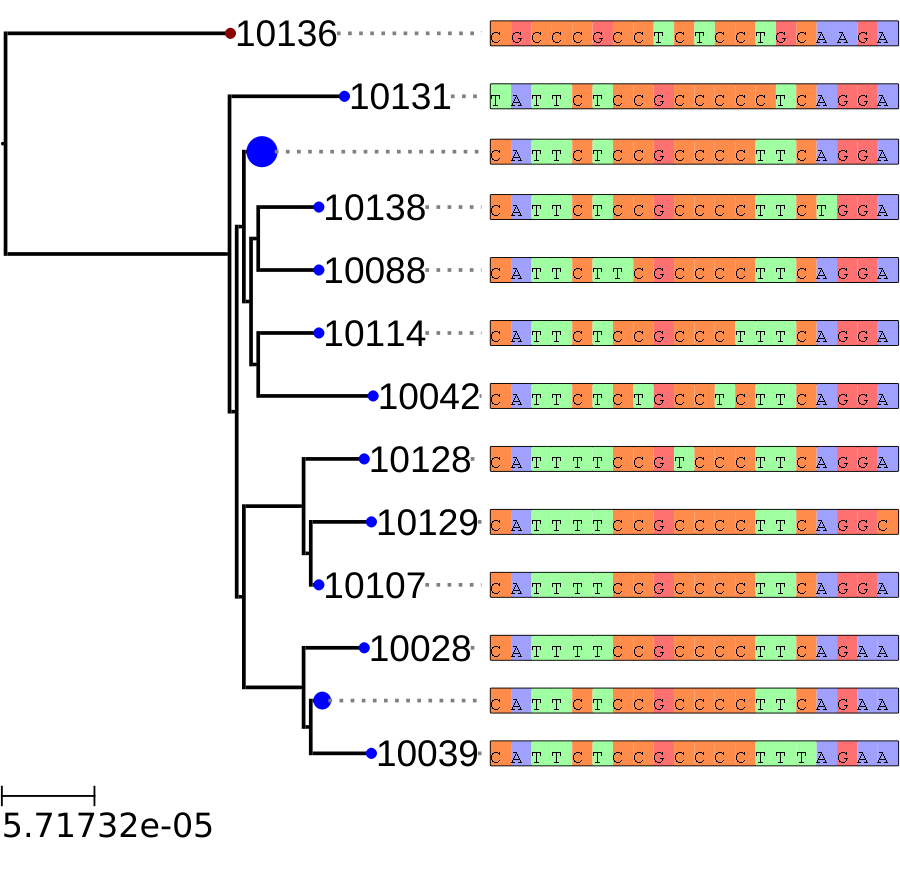

In [11]:
# Collapse identical sequences into a single node and write into a fasta file
collapsed_consensus = {genome[0]: len(genome) for genome in unique_consensus.values()}
collapsed_records = [SeqRecord.SeqRecord((boat_genomes[spid]), id=spid) for spid in collapsed_consensus.keys()]
SeqIO.write(collapsed_records, "results/consensus/condensed-boat-sequences.fa", "fasta")

# Only make the tree if it hasn't already been made - otherwise this notebook takes quite a while to run. 
if not os.path.exists("results/phylogeny/condensed-boat-sequences.aligned.fa.treefile"):
    make_tree(fastapath = "results/consensus/condensed-boat-sequences.fa", outpath = outpath, prefix = "condensed-boat-sequences", large = False, mask = False)

## == Make the figure == ##
t = Tree("results/phylogeny/condensed-boat-sequences.aligned.fa.treefile", format = 1)   

# Simple midpoint rooting is sufficent
root_point = t.get_midpoint_outgroup()
t.set_outgroup(root_point)

# Tree style -- applies to the whole tree
ts = TreeStyle()
ts.show_branch_support = False
ts.branch_vertical_margin = 10 
ts.draw_guiding_lines = True

# Node styles -- applies to nodes only 
internalstyle = NodeStyle()
internalstyle["shape"] = "circle"
internalstyle["size"] = 1
internalstyle["fgcolor"] = "black"
internalstyle["hz_line_width"] = 2
internalstyle["vt_line_width"] = 2

for n in t.traverse():
    if n.is_leaf(): 
        leafstyle = NodeStyle()
        leafstyle["shape"] = "circle"
        leafstyle["hz_line_width"] = 2
        leafstyle["vt_line_width"] = 2
         
        if n.name == "10136":
            leafstyle["size"] = 5 
            leafstyle["fgcolor"] = "darkred"
        elif collapsed_consensus[n.name] == 3:
            leafstyle["size"] = 5 * math.sqrt(collapsed_consensus[n.name])
            leafstyle["fgcolor"] = "blue"
        elif collapsed_consensus[n.name] == 10:
            leafstyle["size"] = 5 * math.sqrt(collapsed_consensus[n.name])
            leafstyle["fgcolor"] = "blue"
        else:
            leafstyle["size"] = 5 
            leafstyle["fgcolor"] = "blue"
            
        n.set_style(leafstyle)
    else: 
        n.set_style(internalstyle)

# Apply faces to the leaves to demonstrate differences from consensus sequence 
for leaf in t.iter_leaves():
    
    if leaf.name == "10136":
        seqface = SequenceFace(seq_annotation[leaf.name], seqtype= "nt")
        seqface.margin_left = 5
        #refface = SequenceFace(''.join([snp[1][1] for snp in sorted(consensus_differences, key = (lambda s: s[0]))]), seqtype= "nt")
        #refface.margin_left = 5
        #refface.margin_bottom = 5
        #leaf.add_face(refface, 1, "aligned")
        leaf.add_face(seqface, 1, "aligned")
        #leaf.add_face(TextFace("Reference"), 0, "aligned")

    else:   
        seqface = SequenceFace(seq_annotation[leaf.name], seqtype= "nt")
        seqface.margin_left = 5
        leaf.add_face(seqface, 1, "aligned")
        if collapsed_consensus[leaf.name] > 1:
            leaf.name = ""

t.ladderize()
t.render("results/phylogeny/condensed-custom-boat-sequences.svg", w=10, units="in", tree_style = ts)     
t.render("%%inline", w=10, units="in", tree_style = ts)    

In [12]:
# Write out the annotations for making this plot in R
pd.DataFrame.from_dict(
{spid: [nt for nt in seq_annotation] for spid, seq_annotation in seq_annotation.items()},
    orient='index',
    columns= [str(snp[0] + 1) for snp in sorted(snps, key = (lambda s: s[0])) if snp not in all_shared_variants],
).to_csv("results/phylogeny/sequence_annotation_matrix.csv")


## Global Analysis

This portion of the analysis includes additional genomes from GISIAD. This is used for two main types of phylogenies: 
1. Boat sequences that we **did not** re-sequence that we wanted to include in our analysis. 
2. Genomes from GISAID that are 'representative' of those circulating at the time of the outbreak and close genomes from BLAST

Here is the metadata for all GISAID sequences as of `08-02-2021`: 

In [13]:
# Path to all of the fasta sequences in GISAID as of 08/04/21
all_fastas_path = "config/gisaid/2021-08-04_GISAID_sequences.fasta"

# Import all of the metadata from GISIAD 
GISAID_metadata = pd.read_table("config/gisaid/2021-08-02-GISAID-metadata.tsv", low_memory=False)
GISAID_Epi_metadata = pd.read_table("config/gisaid/2021-08-03-GISAID-Epi-Metadata.tsv", low_memory=False)


#### GISAID Boat Comparison

These are just the sequences on the boat that we have replicate deep-sequencing runs for. It's also important to look at the remaining sequences (**15 samples with Ct > 20**). Also, I want to see where these sequences fall in the global phylogeny as well as the local washington phylogeny. 

To get as many of the relevant boat sequences as possible, I searched GISAID for all strains relevant to the boat. I took the 72 patient samples that we had data for from Pavitra and converted the internal SpID into a strain name to search in the GISAID metadata. -- **Apply the same quality standards as the main sequences**

In [14]:
# Read in the SpIDs from the supplement of https://doi.org/10.1128/JCM.02107-20
boat_metadata = pd.read_csv("config/data/Boat_Sample_Metadata.csv")
strains_to_search  = [f"hCoV-19/USA/WA-UW-{spid}/2020" for spid in boat_metadata["SpID"]]

# Get the GISAID IDs from these strains
GISAID_metadata_boat = GISAID_metadata[GISAID_metadata['Virus name'].isin(strains_to_search)]
GISAID_metadata_boat.to_csv("config/gisaid/boat.csv") 
GISAID_boat_accessions = GISAID_metadata_boat['Accession ID'].tolist()

# Go through all of the fasta files to get the sequences for each of the samples on the boat. 
GISAID_boat_sequences = {record.name.split('/')[2].split("-")[-1]: record.seq for record in SeqIO.parse(all_fastas_path, "fasta") if (record.id).split("|")[0] in strains_to_search}


How similar are the consensus sequences on GISIAD to their counterparts from my analysis? 

In [15]:
for spid, genome in boat_genomes.items(): 
    
    # Get the gisaid version of the custom genome
    gisaid_genome = GISAID_boat_sequences[spid]
    
    # Make a record object for the custom genome
    custom_record = SeqRecord.SeqRecord(genome, id=f"custom")
    # Make a record object for the GISAD genome
    gisaid_record = SeqRecord.SeqRecord(gisaid_genome, id=f"gisaid")
    
    # Export the sequences to a fasta file for alignment
    SeqIO.write([custom_record, gisaid_record], "comparison.fa", "fasta")
    
    # Align the two sequences with Mafft
    mafft_cline = MafftCommandline(input="comparison.fa")
    stdout, stderr = mafft_cline()
    
    # Make a dictionary to compare the alignment
    alignment_dict = {record.name: "".join(base if base in 'atcgn-' else 'n' for base in record.seq) for record in SeqIO.parse(StringIO(stdout), 'fasta')}

    # Get the non gap or 'n' differences
    differences = [(pos, alleles[0], alleles[1]) for pos, alleles in enumerate(zip(alignment_dict['custom'], alignment_dict['gisaid'])) if alleles[0] != alleles[1] and alleles[0] not in "-n" and alleles[1] not in "-n"]

    print(f"\nFor patient {spid}, the differences between the custom and GISAID genome are:\n")
    for dif in differences: 
        print(f"Position: {dif[0]}, Custom: {dif[1]}, GISAID: {dif[2]}")
        
# When finished, remove the temporary fasta file. 
out = os.system("rm -f comparison.fa")
if out == 0: 
    print("\nRemoved temp fasta.")


For patient 10114, the differences between the custom and GISAID genome are:

Position: 29858, Custom: t, GISAID: a
Position: 29860, Custom: g, GISAID: a
Position: 29861, Custom: g, GISAID: a
Position: 29863, Custom: g, GISAID: a
Position: 29866, Custom: t, GISAID: a
Position: 29867, Custom: g, GISAID: a

For patient 10117, the differences between the custom and GISAID genome are:

Position: 29860, Custom: g, GISAID: a
Position: 29861, Custom: g, GISAID: a
Position: 29863, Custom: g, GISAID: a
Position: 29866, Custom: t, GISAID: a
Position: 29867, Custom: g, GISAID: a

For patient 10118, the differences between the custom and GISAID genome are:

Position: 29860, Custom: g, GISAID: a
Position: 29861, Custom: g, GISAID: a
Position: 29863, Custom: g, GISAID: a
Position: 29866, Custom: t, GISAID: a
Position: 29867, Custom: g, GISAID: a

For patient 10127, the differences between the custom and GISAID genome are:

Position: 12, Custom: t, GISAID: c
Position: 29860, Custom: g, GISAID: a
Pos

It seems like all of the single nucleotide differences between the GISAID sequences and the custom sequences are in where the Poly-A sequence starts. I can simply mask those bases when doing any kind of phylogenetic analysis with the extra sequences. 

In addition, there is a `c` at position `13` that seems to show up in the GISAID sequences. This is a difference with respect to the reference. I don't have this in the custom sequence. It would be a `T13C` change in some samples. There is one other discrepency in sample `10091` at position `36`. I have the base as a reference base `C` when they have a polymorphism at this position `C36T`. 

It seems possible that consensus at position `13` is `C`, but there is never enough coverage to annotate this. As for the `C36T` mutation in `10091`, that doesn't seem to exist (I looked in IGV for that sample). 

Here, I assembled a fasta file with all of the sequences from our analysis and the remaining sequences from the boat. I masked the untranslated regions, **although it might make sense to only mask the regions from the above analysis where there are discepencies.**

In [16]:
# Check if this phylogeny already exists -- if not, make the appropriate files
if not os.path.exists("results/phylogeny/all-boat-sequences.aligned.fa.treefile"):

    records = []
    for spid in set(list(boat_genomes.keys()) + list(GISAID_boat_sequences.keys())): 
        # Try to see if the patient has a genome record in the illumina assemblies. If not, get GISAID.
        try: 
            record = SeqRecord.SeqRecord((boat_genomes[spid]), id=spid)
        except: 
            record = SeqRecord.SeqRecord((GISAID_boat_sequences[spid]), id=spid)

        records.append(record)
    
    SeqIO.write(records, "results/consensus/all-boat-sequences.fa", "fasta")
    make_tree(fastapath = "results/consensus/all-boat-sequences.fa", outpath = outpath, prefix = "all-boat-sequences", mask = True, large = True)


Aligning the fasta file: results/consensus/all-boat-sequences.fa

Finshed aligning file. Alignment is located at results/phylogeny/all-boat-sequences.aligned.fa

Building treefile: results/phylogeny/all-boat-sequences.aligned.fa.treefile

Finished building treefile.



Here is the tree with **all of the sequences from the boat**. I included any sequence for which there were duplicates. If there weren't duplicates, I included the assembled genome from GISAID.

*What's the best way to root this phylogenetic tree?*

If I exclude the the 5' and 3' UTRs from this tree because I'm unsure of the coverage of the samples that we didn't resequence. The outgroup looks like `10136` using midpoint rooting. This is consistent with our expectations. 
Furthermore, the tree isn't as noticibly split based on the assembly method (Custom vs. GISAID). 

Along with `10136`, `10115` is pretty distant from the rest of the boat sequences. 

### SNP annotated Boat tree 

Here is the phylogenetic relationship between the boat sequences - those that we resequenced and those that were previously published - where the brances are annotated with infered SNPs from the ancestral state reconstruction function of `IQtree`.

**Importantly**, this state reconstruction is also used to infer sequence of the boat consensus. All 'fixed' mutations in the paper will be called relative to this boat consensus. 

In [17]:
## === Make the substitution matrix for internal nodes and tips === ##
# Adapted from J. Bloom 

alignment = "results/phylogeny/all-boat-sequences.aligned.fa"
state_file = "results/phylogeny/all-boat-sequences.aligned.fa.state"
site_offset = 265 # Start of ORF1ab 

# Get the genome sequences for each tip
tip_to_seq = {record.id: list(str(record.seq).upper()) for record in SeqIO.parse(alignment, 'fasta')}

# Convert the sequences into the same format of IQtree `-asr` .state file
tip_states = (
    pd.DataFrame.from_dict(tip_to_seq, orient='index')
    .rename_axis('Node')
    .reset_index()
    .melt(id_vars='Node',
          var_name='Site',
          value_name='State',
          )
    .assign(Site=lambda x: x['Site'] + 1)
    )

# Import the internal states from IQtree `-asr` .state file
internal_states = (
    pd.read_csv(state_file,
                sep='\t',
                comment='#',
                usecols=['Node', 'Site', 'State'])
    )

# Combine and format the internal and tip states
states = (
    internal_states
    .append(tip_states)
    .assign(Site = lambda x: x['Site'] + site_offset, # to get the actual position
            n_states_at_site = lambda x: x.groupby('Site')['State'].transform('nunique'),
            )
    .query('n_states_at_site > 1')
    .drop(columns='n_states_at_site')
    )

states_dict = states.set_index(['Node', 'Site'])['State'].to_dict()

nodes = states['Node'].unique().tolist()

sites = sorted(states['Site'].unique())

# Find all pairwise differeces between the nodes/tips
subs_matrix = {}  # keyed by (parent, descendant)
for n1, n2 in product(nodes, nodes):
    subs = []
    for site in sites:
        nt1 = states_dict[(n1, site)]
        nt2 = states_dict[(n2, site)]
        if nt1 != nt2:
            if nt1 in {'A', 'C', 'G', 'T'} and nt2 in {'A', 'C', 'G', 'T'}:
                subs.append(f"{nt1}{site}{nt2}")
    subs_matrix[(n1, n2)] = ', '.join(subs)


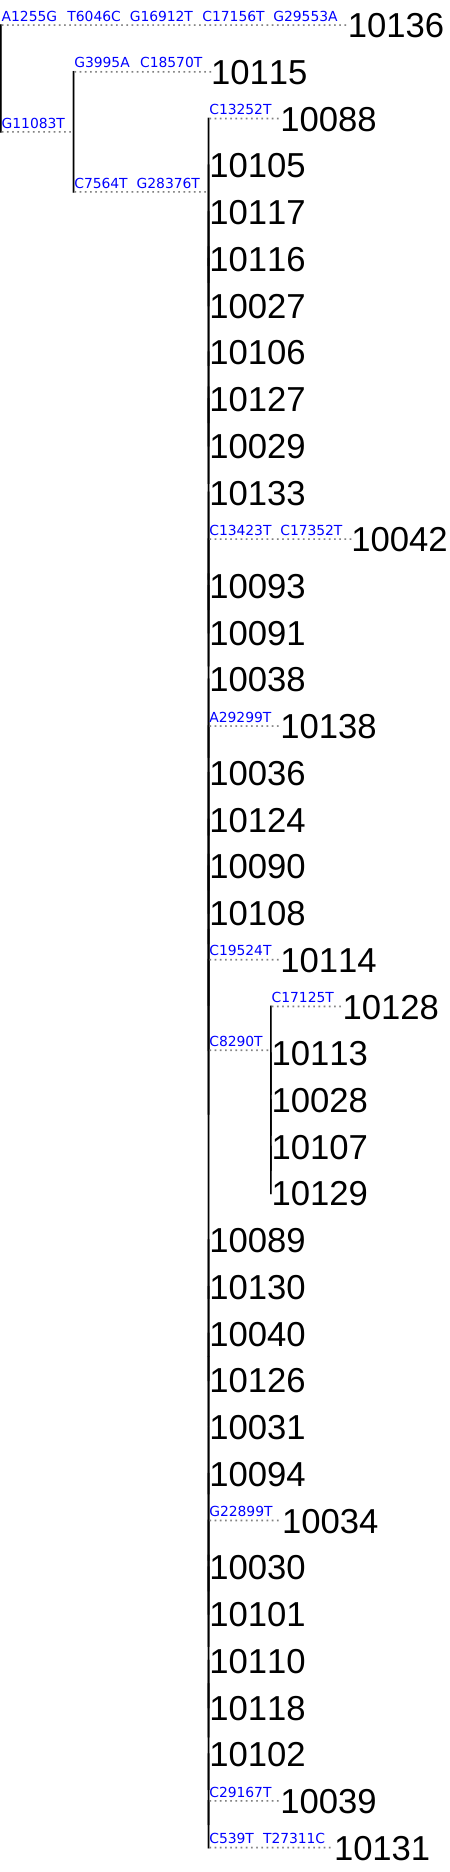

In [18]:
# With midpoint rooting
t = Tree("results/phylogeny/all-boat-sequences.aligned.fa.treefile", format = 1)
 
    
for n in t.get_descendants():
    if not n.is_leaf():
        name, support = n.name.split("/")
        n.name = name
        n.support = support 
#         if n.support <= 50:
#             n.delete()
        
        
# Tree style
ts = TreeStyle()
ts.show_branch_length = False
ts.show_branch_support = False
ts.branch_vertical_margin = 3
ts.scale = 10
ts.show_scale = False
 
nstyle_dict = {'hz_line_width': 1,
               'vt_line_width': 1,
               'hz_line_color': 'black',
               'vt_line_color': 'black',
               'size': 0}

# label nodes
for n in t.traverse():
    if n != t:
        subs = subs_matrix[(n.up.name.split("/")[0], n.name.split("/")[0])]
        icol = 0
        for sub in subs.split(', '):
            if sub:
                n.add_face(TextFace(f"{sub}  ",
                                         fsize=4,
                                         fgcolor="blue",),
                           column=icol,
                           position='branch-top',
                           )
                icol += 1
    
    nstyle = NodeStyle(**nstyle_dict)
    
    n.set_style(nstyle)

refnode = t.search_nodes(name='NC_045512.2')[0]
refnode.delete()


root_point = t.search_nodes(name='10136')[0]
t.set_outgroup(root_point)

t.ladderize()
t.render("results/phylogeny/all-boat-sequences.png", w=15, units="in", tree_style = ts)  
t.render("%%inline", w=5, units="in", tree_style = ts)  

### Context of the Outbreak

The next thing that I wanted to do was establish the context of the outbreak. I wanted to do this for two reasons. First, I want to demonstrate that the outbreak was monophyletic and stemed from a single introduction of SARS-CoV-2 on the boat that spread amoung passangers. Second, I want to see if intrahost mutations that arose on the boat showed up elsewhere in the local washington phylogeny. 

#### Global Phylogeny

Here, I want to show where the boat samples sit on the global phylogeny. To do this I included all circulating clades and samples that were close to the boat sequences specifically. The help with the visualization, I only incded a limited number of samples from each clade. 

*Ciculating clades up to the date of collection `05/03/2020` were: 19A, 19B, 20A, 20C, 20B, 20D, and 20F*

In [19]:
# Clades circulating at the time of, or before, the outbreak on the boat. 
clades_of_interest = ['19A','19B','20A','20B','20C','20D','20E (EU1)','20F']

# Max number to sample from each clade
n_sample = 25

# List to contain the clade specific samples
clade_dfs = []

for clade in clades_of_interest: 
    # Get the accessions for every sequence in a given clade 
    accessions = GISAID_Epi_metadata[GISAID_Epi_metadata.Nextstrain_clade == clade].gisaid_epi_isl
    # Subtract the boat accessions
    accessions = set(accessions) - set(GISAID_boat_accessions)
    # Subset the metadata based on these sequences 
    clade_subset = GISAID_metadata[GISAID_metadata['Accession ID'].isin(accessions)]
    
    # Filter based on quality
    # high coverage
    clade_subset = clade_subset[clade_subset['Is high coverage?'] == True]
    # less than 5% N's 
    clade_subset = clade_subset[clade_subset['N-Content'] <= 0.05]
    # complete genome
    clade_subset = clade_subset[clade_subset['Is complete?'] == True]
    # host is human
    clade_subset = clade_subset[clade_subset['Host'] == "Human"]
    
    if len(clade_subset) > n_sample: 
        clade_subset = clade_subset.sample(n = n_sample, random_state = 7) # Set the seed for reproducibility
       
    clade_subset['clade'] = clade
    
    clade_dfs.append(clade_subset)
    

# Combine all of these representative sequences     
clade_df = pd.concat(clade_dfs)

#### BLAST Database

After I got representative sequences from each clade, I needed to get similar sequeucnes from `BLAST`. I think it makes the most sense to constrain the BLAST search to sequences from around the time and region of the outbreak. 

In [20]:
# Check if this phylogeny already exists
if not os.path.exists("results/phylogeny/blast_database.fasta"):
    
    print("Making the BLAST databse\n")
    
    # Get sequences from around the time of the outbreak ~~ '2020-05-30'
    blast_sequence_metadata = GISAID_metadata[(GISAID_metadata['Collection date'] >= '2020-04-30') & (GISAID_metadata['Collection date'] <= '2020-06-30')]
    # Location is Washington State
    blast_sequence_metadata = blast_sequence_metadata[blast_sequence_metadata['Location'] == "North America / USA / Washington"]
    # high coverage
    blast_sequence_metadata = blast_sequence_metadata[blast_sequence_metadata['Is high coverage?'] == True]
    # less than 5% N's 
    blast_sequence_metadata = blast_sequence_metadata[blast_sequence_metadata['N-Content'] <= 0.05]
    # complete genome
    blast_sequence_metadata = blast_sequence_metadata[blast_sequence_metadata['Is complete?'] == True]
    # host is human
    blast_sequence_metadata = blast_sequence_metadata[blast_sequence_metadata['Host'] == "Human"]
    # not including the boat sequences
    blast_sequence_metadata = blast_sequence_metadata[~blast_sequence_metadata['Accession ID'].isin(GISAID_boat_accessions)]

    # Get the virus names for the sequences to make the blast database and remove boat samples
    blast_virus_names = set(blast_sequence_metadata['Virus name'].tolist()) - set(GISAID_metadata_boat['Virus name'].to_list())
    # Get these sequences in a dictionary
    blast_virus_sequences = [record for record in SeqIO.parse(all_fastas_path, "fasta") if (record.id).split("|")[0] in blast_virus_names]

    # Write these out to a fasta file 
    SeqIO.write(blast_virus_sequences, "results/phylogeny/blast_database.fasta", "fasta")
    print("(1/3) Finished downloading the eligible samples for the BLAST database.\n")

    # Build the BLAST database
    call(f"makeblastdb -in results/phylogeny/blast_database.fasta -dbtype nucl", shell=True)
    print("(2/3) Finished making the BLAST databse with the eligible samples.\n")

# For each boat genome, make the query fasta
all_matches_list = []
colnames = ["SpID", "Subject", "Perc_Identity", "Alignment_Length", "Mismatches", "Gap_Opens", "Q_start", "Q_end", "S_start", "S_end", "Evalue", "Bit_Score"]

for spid, genome in boat_genomes.items(): 
    custom_record = SeqRecord.SeqRecord(genome, id=spid)
    SeqIO.write(custom_record, "results/phylogeny/query.fasta", "fasta")
    
    # Query the database
    print(f"Querying the BLAST database for sample {spid}\n")
    call(f"blastn -db results/phylogeny/blast_database.fasta -query results/phylogeny/query.fasta -out results/phylogeny/results.out -outfmt 7", shell=True)
    
    # Import the table of matches
    match_df = pd.read_table("results/phylogeny/results.out", comment='#', names=colnames)
    match_df = match_df.head(25)
    
    # add to a list of dataframes
    all_matches_list.append(match_df)

print("(3/3) Finished BLASTing each sample.\n")
    
# Combine all of these and remove the duplicates
closest_sequences = pd.concat(all_matches_list).drop_duplicates(['Subject'])

# Remove the temp files
os.system("rm -f results/phylogeny/results.out results/phylogeny/query.fasta")


Making the BLAST databse

(1/3) Finished downloading the eligible samples for the BLAST database.

(2/3) Finished making the BLAST databse with the eligible samples.

Querying the BLAST database for sample 10114

Querying the BLAST database for sample 10117

Querying the BLAST database for sample 10118

Querying the BLAST database for sample 10127

Querying the BLAST database for sample 10128

Querying the BLAST database for sample 10129

Querying the BLAST database for sample 10130

Querying the BLAST database for sample 10131

Querying the BLAST database for sample 10136

Querying the BLAST database for sample 10138

Querying the BLAST database for sample 10027

Querying the BLAST database for sample 10028

Querying the BLAST database for sample 10029

Querying the BLAST database for sample 10039

Querying the BLAST database for sample 10040

Querying the BLAST database for sample 10042

Querying the BLAST database for sample 10088

Querying the BLAST database for sample 10089

Query

0

#### Representative Phylogeny 

This phylogeny contains sequences sampled from each clade circulating globally at the time of the outbreak. The phylogeny also contains the boat sequences as well as a non-redundant list of the top 25 matches to each sample by `BLASTN` (see above code). 

In [23]:
# Check if this phylogeny already exists
if not os.path.exists("results/phylogeny/global_phylogeny.aligned.fa.treefile"):
    
    # Check if this fasta already exists
    if not os.path.exists("results/phylogeny/global_phylogeny.fa"):

        # Parse the sequence names from the dataframe
        blast_virus_names = [virus.split('|')[0] for virus in closest_sequences.Subject.tolist()]
        # Get these sequences from the GISAID metadata
        blast_df = GISAID_metadata[GISAID_metadata['Virus name'].isin(blast_virus_names)]
        # Concat with the clade sequences and boat sequences
        global_phylogeny_metadata = pd.concat([GISAID_metadata_boat, blast_df, clade_df])

        # 1. Get the virus names for the sequences to make the blast database and remove boat samples
        virus_names = set(global_phylogeny_metadata['Virus name'].tolist())
        # Get these sequences in a dictionary
        virus_sequences = [record for record in SeqIO.parse(all_fastas_path, "fasta") if (record.id).split("|")[0] in virus_names]

        # Write these out to a fasta file 
        SeqIO.write(virus_sequences, "results/phylogeny/global_phylogeny.fa", "fasta")
        print("(1/3) Finished downloading the eligible samples for the global phylogeny.\n")

    make_tree(fastapath = "results/phylogeny/global_phylogeny.fa", outpath = outpath, prefix = "global_phylogeny")

    

(1/3) Finished downloading the eligible samples for the global phylogeny.

Aligning the fasta file: results/phylogeny/global_phylogeny.fa

Finshed aligning file. Alignment is located at results/phylogeny/global_phylogeny.aligned.fa

Building treefile: results/phylogeny/global_phylogeny.aligned.fa.treefile

Finished building treefile.



### Ancestral Boat Sequence

Here, I determine the sequences of the boat consensus. This corresponds to the most likely sequence of the common ancestor to all genomes sampled from the boat. 

There is some uncertaintly whether to include `10115` or not in this reconstruction. 

In [46]:
t = Tree("results/phylogeny/global_phylogeny.aligned.fa.treefile", format = 1)
state_file = "results/phylogeny/global_phylogeny.aligned.fa.state"

# Get only the genomes that belong to the same clade all of the boat samples 
boat_minimum_clade = [x for x in GISAID_metadata_boat['Virus name'].tolist() if x.split("/")[2].split("-")[-1] not in ('10136', '10115')]
boat_all_clade = [x for x in GISAID_metadata_boat['Virus name'].tolist()]
boat_minimum_names = [n.name for n in t.get_leaves() if n.name.split("|")[0] in boat_minimum_clade]
boat_all_names = [n.name for n in t.get_leaves() if n.name.split("|")[0] in boat_all_clade]

# Get the samples that break the monophyletic relationship
non_boat_samples = [n.name.split("|")[0] for n in t.check_monophyly(boat_minimum_names, "name")[-1]]
print(f"Samples that violate monophyletic boat clade: {non_boat_samples}")

# Ancestral State = without 10115 and 10136
boat_consensus_snps = ancestral_snps(t, state_file, boat_minimum_names, reference, offset = 265)
boat_consensus_snps.to_csv("results/phylogeny/boat_consensus.csv")
print("\n", boat_consensus_snps)

Samples that violate monophyletic boat clade: ['hCoV-19/USA/WA-UW-10510/2020', 'hCoV-19/USA/WA-UW-10521/2020']

          POS REF ALT   SNP
1058    1059   C   T  True
3036    3037   C   T  True
7563    7564   C   T  True
11082  11083   G   T  True
14407  14408   C   T  True
23402  23403   A   G  True
25562  25563   G   T  True
28375  28376   G   T  True


#### Closer look at the boat clade.

From the above image, it's clear that sample `10136` belongs somewhere else on the phylogeny and was perhaps infected elsewhere on the boat.

Another interesting observation is that two samples collected on the same day from the UW virology lab also show up as part of the boat clade. The branch length for one sample looks especially long. However, the other sample seems closer to the main one. These don't appear in the sample sheet for what was collected on the boat. That doesn't mean that they weren't resampled at a later date. 

What are the names of the two samples in this part of the subtree? 

In [57]:

print(non_boat_samples)
[n.name for n in t.check_monophyly(boat_minimum_names, "name")[-1]]


['hCoV-19/USA/WA-UW-10510/2020', 'hCoV-19/USA/WA-UW-10521/2020']


['hCoV-19/USA/WA-UW-10027/2020|2020-05-29|2020-06-06',
 'hCoV-19/USA/WA-UW-10089/2020|2020-05-29|2020-06-06',
 'hCoV-19/USA/WA-UW-10090/2020|2020-05-29|2020-06-06',
 'hCoV-19/USA/WA-UW-10138/2020|2020-05-29|2020-06-06',
 'hCoV-19/USA/WA-UW-10094/2020|2020-05-29|2020-06-06',
 'hCoV-19/USA/WA-UW-10131/2020|2020-05-29|2020-06-06',
 'hCoV-19/USA/WA-UW-10091/2020|2020-05-29|2020-06-06',
 'hCoV-19/USA/WA-UW-10116/2020|2020-05-29|2020-08-10',
 'hCoV-19/USA/WA-UW-10118/2020|2020-05-29|2020-06-06',
 'hCoV-19/USA/WA-UW-10127/2020|2020-05-29|2020-06-06',
 'hCoV-19/USA/WA-UW-10034/2020|2020-05-29|2020-08-09',
 'hCoV-19/USA/WA-UW-10108/2020|2020-05-29|2020-06-06',
 'hCoV-19/USA/WA-UW-10114/2020|2020-05-29|2020-06-06',
 'hCoV-19/USA/WA-UW-10124/2020|2020-05-29|2020-08-09',
 'hCoV-19/USA/WA-UW-10029/2020|2020-05-29|2020-06-06',
 'hCoV-19/USA/WA-UW-10133/2020|2020-05-29|2020-08-09',
 'hCoV-19/USA/WA-UW-10093/2020|2020-05-29|2020-06-06',
 'hCoV-19/USA/WA-UW-10028/2020|2020-05-29|2020-06-06',
 'hCoV-19/

Two of the top 5 samples that weren't part of the boat have the longest branch lenghts. However, one of theses has a comparable branch length to other samples. 

How different are these samples from the deep-sequenced samples from the boat? The number of consensus differences can inform us about how likely these were to have resulted from direct transmission from any one of our samples.

In [26]:
# Check if this phylogeny already exists
if not os.path.exists("results/phylogeny/with_outliers.fa"):
    
    # Get the records for the non-boat genomes
    non_boat_genomes = [record for record in SeqIO.parse(all_fastas_path, "fasta") if (record.id).split("|")[0] in non_boat_samples]
    
    # Make a dictionary by adding the new samples to the boat dictionary. 
    for record in non_boat_genomes: 
        SpID = record.name.split("/")[2].split('-')[-1]
        if SpID not in boat_genomes.keys():
            boat_genomes[SpID] = record.seq
    
    # Get a list of records from the updated boat dicitonary
    records = [SeqRecord.SeqRecord(seq, id=spid) for spid, seq in boat_genomes.items()]

    # Add the reference genome
    records.append(SeqRecord.SeqRecord(Seq.Seq("".join(reference).lower()), id = "reference"))

    # Write out a new fasta with the non-boat outliers
    SeqIO.write(records, "results/phylogeny/with_outliers.fa", "fasta")

make_tree(fastapath = "results/phylogeny/with_outliers.fa", outpath = outpath, prefix = "with_outliers", large = False, mask = False)



Aligning the fasta file: results/phylogeny/with_outliers.fa

Finshed aligning file. Alignment is located at results/phylogeny/with_outliers.aligned.fa

Building treefile: results/phylogeny/with_outliers.aligned.fa.treefile

Finished building treefile.



In [27]:
# Hamming distance not including n's or gaps
distance2 = lambda x,y : sum(c1 != c2 for c1, c2 in zip(x, y) if "-" not in {c1, c2} and "n" not in {c1, c2})
# Get all of the aligned records as a dictionary. 
aligned_records = {record.id: str(record.seq) for record in SeqIO.parse("results/phylogeny/with_outliers.aligned.fa", "fasta")}
# Calculate all of the edit distances. 
edit_distance = {f"{g1}-{g2}": distance2(aligned_records[g1], aligned_records[g2]) for g1, g2 in combinations(aligned_records.keys(), 2) if "10136" not in {g1, g2}}

print("10510 average edit distance:", sum(v for k,v in edit_distance.items() if '10510' in k.split("-"))/ len([v for k,v in edit_distance.items() if '10510' in k.split("-")]))

print("10521 average edit distance:", sum(v for k,v in edit_distance.items() if '10521' in k.split("-"))/len([v for k,v in edit_distance.items() if '10510' in k.split("-")]))


10510 average edit distance: 5.64
10521 average edit distance: 12.68


In [50]:
# Reference Sequence 
aligned_records = {record.id: str(record.seq) for record in SeqIO.parse("results/phylogeny/with_outliers.aligned.fa", "fasta")}
reference = [base.upper() for base in aligned_records['reference']]
aligned_records.pop("reference")

# Save a dict of the consensus SNPs for each patient
consesus = {}

# Populate the dict
for patient, genome in aligned_records.items():
    differences = []
    for i, bases in enumerate(zip(genome.upper(), reference)):
        if len(set(bases)) > 1 and "-" not in bases and "N" not in bases: 
            differences.append((i, bases))
    consesus[patient] = differences

# Get a set of all unique SNPs 
consensus_differences = set(snp for snp_list in consesus.values() for snp in snp_list)

# Fill in the missing SNPs in the dict
for patient, snps in consesus.items(): 
    for snp in consensus_differences: 
        if snp not in snps:
            consesus[patient].append((snp[0], (snp[1][1], snp[1][1])))


# Condense the identical sequences
unique_consensus = {}

for patient, snps in consesus.items(): 
    con = ' '.join([snp[1][0] for snp in sorted(snps, key = (lambda s: s[0]))])
    if con in unique_consensus.keys():
        unique_consensus[con].append(patient)
    else: 
        unique_consensus[con] = [patient]

# Print the differences for each patient 
print(f"Position: {' '.join([str(snp[0]) for snp in sorted(consensus_differences, key = (lambda s: s[0]))])}")
print(f"\nReference: \t\t\t\t{' '.join([snp[1][1] for snp in sorted(consensus_differences, key = (lambda s: s[0]))])}")

for snps, patients in unique_consensus.items(): 
    print(f"\n{'/'.join(patients)}: \n\t\t\t\t\t{snps}")


Position: 12 17 18 19 240 538 579 1058 1254 3036 4228 6045 7563 8289 11082 13251 13422 14221 14407 16911 17124 17155 17177 17178 17181 17351 19523 23402 25562 27310 28375 29166 29298 29552 29863 29866 29867 29869

Reference: 				T T C C C C T C A C A T C C G C C T C G C C T G G C C A G T G C A G G T G C

NC_045512.2: 
					T T C C C C T C A C A T C C G C C T C G C C T G G C C A G T G C A G G T G C

10114: 
					T T C C T C T T A T A T T C T C C T T G C C T G G C T G T T T C A G G T G A

10117/10118/10127/10130/10027/10040/10089/10091/10102/10110: 
					T T C C T C T T A T A T T C T C C T T G C C T G G C C G T T T C A G G T G A

10128: 
					T T C C T C T T A T A T T T T C C T T G T C T G G C C G T T T C A G G T G A

10129: 
					T T C C T C T T A T A T T T T C C T T G C C T G G C C G T T T C A G G T G C

10131: 
					T T C C T T T T A T A T T C T C C T T G C C T G G C C G T C T C A G G T G A

10136: 
					T T C C T C T T G T A C C C G C C T T T C T T G G C C G T T G C A A G T G A

1013

Interestingly, there are 0 consensus differences between `10510` and three other samples `10129/10028/10107` if you disregard the first and last 100 nucleotides as well as n's or gaps in the sequence. Essentially, they seem to have identical SNPs. I'm not fully sure what this means for the samples on the boat.

Unfortunately, there is a 7 nucleotide un-resolved stretch from positions: `23298 - 23304`. Otherwise, the genome is identical outside of the non-coding UTRS. 

In [29]:
make_tree(fastapath = "results/phylogeny/with_outliers.fa", outpath = outpath, prefix = "with_outliers", large = True, mask = False)
aligned_records = {record.id: str(record.seq) for record in SeqIO.parse("results/phylogeny/with_outliers.aligned.fa", "fasta")}
[(i+1, nts) for i, nts in enumerate(zip(aligned_records['10510'], aligned_records['10107'])) if nts[0] != nts[1]]


Aligning the fasta file: results/phylogeny/with_outliers.fa

Finshed aligning file. Alignment is located at results/phylogeny/with_outliers.aligned.fa

Building treefile: results/phylogeny/with_outliers.aligned.fa.treefile

Finished building treefile.



[(4, ('n', 'a')),
 (13, ('c', 't')),
 (23563, ('n', 't')),
 (23564, ('n', 'g')),
 (23565, ('n', 'c')),
 (23566, ('n', 'a')),
 (23567, ('n', 'g')),
 (23568, ('n', 'g')),
 (23569, ('n', 't')),
 (29864, ('a', 'g')),
 (29867, ('a', 't')),
 (29868, ('a', 'g'))]

Interestingly, there is one SNP difference between some of the sequences on the boat and this sample at position 13. However, this position is so close to the beggining of the genome, it's hard to give it any weight as a real mutation. 

# END